In [1]:
%matplotlib inline   
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
LARGE_FIG_SIZE=(15, 15)

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
import sys
sys.path.append('../')
from utils import utils

In [3]:
titanic = pd.read_csv('train.csv')
utils.nan_info(titanic)

,count,percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

In [203]:
titanic_non_null = titanic.dropna(subset=['Embarked'])
titanic_ft = titanic_non_null.drop('Survived', 1)
titanic_labels = titanic_non_null[['Survived']]
y = titanic_labels.values

In [6]:
from sklearn.tree import export_graphviz
def export_tree(feature_names):
    export_graphviz(
            tree_clf,
            out_file="titanic_tree.dot",
            feature_names=feature_names,
            class_names=['did not survive', 'survived'],
            rounded=True,
            filled=True
        )

In [150]:
fam_names = [n.split(',')[0].split(' ')[0].strip() for n in titanic_non_null['Name'].values]
titles =    [n.split(',')[1].split('.')[0].strip() for n in titanic_non_null['Name'].values]


dft = titanic_non_null.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)
dft['fam_name'] = fam_names
dft['title'] = titles

In [151]:
dft['title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Sir               1
Lady              1
the Countess      1
Mme               1
Jonkheer          1
Ms                1
Capt              1
Don               1
Name: title, dtype: int64

In [152]:
m = dft.apply(lambda row: row['title'] not in ['Mr', 'Mrs', 'Miss', 'Master'], axis=1)
dft.loc[m, 'title'] = 'Other'
dft

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,fam_name,title
0,0,3,male,22.0,1,0,7.2500,S,Braund,Mr
1,1,1,female,38.0,1,0,71.2833,C,Cumings,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Heikkinen,Miss
3,1,1,female,35.0,1,0,53.1000,S,Futrelle,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Allen,Mr
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Montvila,Other
887,1,1,female,19.0,0,0,30.0000,S,Graham,Miss
888,0,3,female,NaN,1,2,23.4500,S,Johnston,Miss
889,1,1,male,26.0,0,0,30.0000,C,Behr,Mr


In [247]:
dft['famSize'] = dft['SibSp'] + dft['Parch']

In [265]:
drop_attr = ['fam_name']
num_attr = ['Age', 'Fare', 'Pclass', 'famSize'] #2
cat_ordinal_attr = ['Sex', 'Embarked'] #1



pipeline = ColumnTransformer([
    ('cat_ordinal', OrdinalEncoder(), cat_ordinal_attr),
    ('num_pipeline', KNNImputer(), num_attr)
])


prepared_columns = cat_ordinal_attr + num_attr

df = pd.DataFrame(pipeline.fit_transform(dft), columns=prepared_columns)
df

,Sex,Embarked,Age,Fare,Pclass,famSize
0,1.0,2.0,22.0,7.2500,3.0,1.0
1,0.0,0.0,38.0,71.2833,1.0,1.0
2,0.0,2.0,26.0,7.9250,3.0,0.0
3,0.0,2.0,35.0,53.1000,1.0,1.0
4,1.0,2.0,35.0,8.0500,3.0,0.0
...,...,...,...,...,...,...
884,1.0,2.0,27.0,13.0000,2.0,0.0
885,0.0,2.0,19.0,30.0000,1.0,0.0
886,0.0,2.0,30.8,23.4500,3.0,3.0
887,1.0,0.0,26.0,30.0000,1.0,0.0


In [285]:
prepared_columns

['Sex', 'Embarked', 'Age', 'Fare', 'Pclass', 'famSize']

In [259]:
pipeline.transformers_[0][1].categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

In [286]:
fare_bins = pd.qcut(df['Fare'], q=8, labels=range(8))
age_bins = pd.qcut(df['Age'], q=10, labels=range(10))
X = np.c_[df.values[:,:2], age_bins.values, fare_bins.values, df.values[:,4:]]
# X = df.values
pd.DataFrame(X, columns=prepared_columns).describe()

,Sex,Embarked,Age,Fare,Pclass,famSize
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.649044,1.535433,4.426322,3.457818,2.311586,0.906637
std,0.477538,0.792088,2.896376,2.330919,0.834700,1.614703
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,2.000000,1.000000,2.000000,0.000000
50%,1.000000,2.000000,4.000000,3.000000,3.000000,0.000000
75%,1.000000,2.000000,7.000000,5.000000,3.000000,1.000000
max,1.000000,2.000000,9.000000,7.000000,3.000000,10.000000


In [272]:
set(pd.qcut(df['Fare'], q=8))

{Interval(-0.001, 7.75, closed='right'),
 Interval(7.75, 7.896, closed='right'),
 Interval(7.896, 9.838, closed='right'),
 Interval(9.838, 14.454, closed='right'),
 Interval(14.454, 24.15, closed='right'),
 Interval(24.15, 31.0, closed='right'),
 Interval(31.0, 69.3, closed='right'),
 Interval(69.3, 512.329, closed='right')}

In [274]:
set(pd.qcut(df['Age'], q=10))

{Interval(0.419, 16.0, closed='right'),
 Interval(16.0, 20.0, closed='right'),
 Interval(20.0, 23.0, closed='right'),
 Interval(23.0, 26.0, closed='right'),
 Interval(26.0, 28.0, closed='right'),
 Interval(28.0, 30.7, closed='right'),
 Interval(30.7, 35.0, closed='right'),
 Interval(35.0, 40.0, closed='right'),
 Interval(40.0, 48.0, closed='right'),
 Interval(48.0, 80.0, closed='right')}

scores

precision 0.875968992248062
recall    0.6647058823529411
f1        0.7558528428093645
accuracy  0.8357705286839145


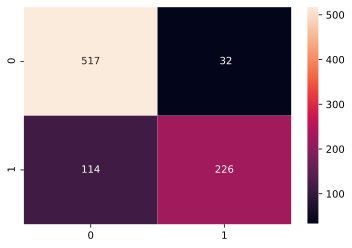

In [287]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(min_samples_leaf=6, min_impurity_decrease=0.001)
tree_clf.fit(X, y.ravel())

y_pred = tree_clf.predict(X)
utils.show_scores(y.ravel(), y_pred)

# from sklearn.model_selection import cross_val_predict
# y_cv_pred = cross_val_predict(tree_clf, X, y.ravel(), cv=10, n_jobs=-1)
# utils.show_scores(y.ravel(), y_cv_pred)

# from sklearn.metrics import accuracy_score
# utils.plot_learning_curves(tree_clf, X, y.ravel(), accuracy_score)

# # cross_val_predict and plot_learning_curves, fits the classifier on subsets of data. Fit again on all the training data
# tree_clf.fit(X, y.ravel())

In [288]:
export_tree(prepared_columns)

scores

precision 0.8426966292134831
recall    0.8333333333333334
f1        0.8379888268156424
accuracy  0.8768577494692145
scores

precision 0.7777777777777778
recall    0.7
f1        0.7368421052631577
accuracy  0.8086124401913876


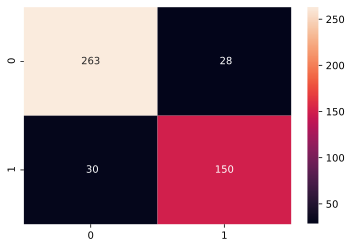

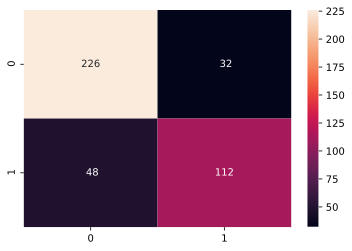

In [180]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.47, random_state=42)
train_index, test_index = list(split.split(X, y))[0]
X_train, X_val, y_train, y_val = X[train_index], X[test_index], y[train_index], y[test_index]
tree_clf.fit(X_train, y_train)
y_train_predict = tree_clf.predict(X_train)
y_val_predict = tree_clf.predict(X_val)

utils.show_scores(y_train.ravel(), y_train_predict)
utils.show_scores(y_val.ravel(), y_val_predict)
export_tree(prepared_columns)

In [225]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer

drop_attr = ['PassengerId', 'Ticket', 'Cabin', 'Age']
num_attr = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch'] #2
cat_ordinal_attr = ['Sex', 'Embarked'] #1

def extract_titles(series):
    return  np.array([ 'Other' if t not in ['Mr', 'Mrs', 'Miss', 'Master'] else t
        for t in [n.split(',')[1].split('.')[0].strip() for n in series.values.ravel()]
    ]).reshape(-1,1)




cat_pipeline = ColumnTransformer([
    ('cat_ordinal', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ord', OrdinalEncoder())]), cat_ordinal_attr),
    ('title', Pipeline([('extract_titles', FunctionTransformer(extract_titles)), ('ord', OrdinalEncoder())]), ['Name']),
    ('passthrough', 'passthrough', num_attr)
])

disc_pipeline = ColumnTransformer([
    ('age', KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal'), [3]),
    ('fare', KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal'), [4])
], remainder='passthrough')


famsize_adder = ColumnTransformer([
    ('famsize_adder', FunctionTransformer(lambda X: np.array(X[:,0] + X[:,1]).reshape(-1,1)), [6,7])
], remainder='passthrough')

pipeline = Pipeline([
    ('cat_pipeline', cat_pipeline), #columns: Sex, Embarked, Name, Age, Fare, Pclass, SibSp, Parch
    ('imputer', KNNImputer()),
    ('disc_pipeline', disc_pipeline), #columns: Age, Fare, Sex, Embarked, Name, Pclass, SibSp, Parch
    ('famsize_adder', famsize_adder), #columns: fam_size, Age, Fare, Sex, Embarked, Name, Pclass
#     ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
])


prepared_columns = ['fam_size', 'Age', 'Fare', 'Sex', 'Embarked', 'Title', 'Pclass']

from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('cat_pipeline',
                 ColumnTransformer(transformers=[('cat_ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('title',
                                                  Pipeline(steps=[('extract_titles',
                                                                   FunctionTransformer(func=<function extract_titles at 0x12489cc10>)),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Name']),
                                                 ('passthrou...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('age',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=10,
                                                                   strategy='uniform'),
                                                  [3]),
                                                 ('fare',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=10),
                                                  [4])])),
                ('famsize_adder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('famsize_adder',
                                                  FunctionTransformer(func=<function <lambda> at 0x123bf4790>),
                                                  [6, 7])]))])

In [227]:
pd.DataFrame(pipeline.fit_transform(titanic_ft), columns=prepared_columns).describe()

,fam_size,Age,Fare,Sex,Embarked,Title,Pclass
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.906637,3.169854,4.573678,0.649044,1.535433,1.906637,2.311586
std,1.614703,1.681026,2.837455,0.477538,0.792088,0.797837,0.834700
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,2.000000,0.000000,1.000000,2.000000,2.000000
50%,0.000000,3.000000,5.000000,1.000000,2.000000,2.000000,3.000000
75%,1.000000,4.000000,7.000000,1.000000,2.000000,2.000000,3.000000
max,10.000000,9.000000,9.000000,1.000000,2.000000,4.000000,3.000000


In [239]:
cat = pipeline['cat_pipeline']

In [243]:
cat.named_transformers_['title'][1].categories_

[array(['Master', 'Miss', 'Mr', 'Mrs', 'Other'], dtype='<U6')]

In [212]:
list(range(2,15,2))

[2, 4, 6, 8, 10, 12, 14]

In [216]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {
        'clf__n_estimators': [100], #100   
        'clf__min_samples_leaf': range(2,15,2),
        'clf__min_impurity_decrease': [0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001],
        'disc_pipeline__fare__n_bins': range(6,24,4),
        'disc_pipeline__fare__strategy': ['uniform', 'quantile'],
        'disc_pipeline__age__n_bins': range(6,24,4),
        'disc_pipeline__age__strategy': ['uniform', 'quantile']
    },
]

clf = pipeline

model_rfc = GridSearchCV(clf, param_grid, cv=4, return_train_score=True, n_jobs=-1, verbose=1, refit=True)
model_rfc.fit(titanic_ft, y.ravel())
print(model_rfc.best_params_, max(model_rfc.cv_results_["mean_test_score"]))
cvres = model_rfc.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#     print(mean_score, params)

Fitting 4 folds for each of 4200 candidates, totalling 16800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

{'clf__min_impurity_decrease': 0.0001, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100, 'disc_pipeline__age__n_bins': 14, 'disc_pipeline__age__strategy': 'quantile', 'disc_pipeline__fare__n_bins': 10, 'disc_pipeline__fare__strategy': 'quantile'} 0.8425544378459177


In [222]:
from scipy.stats import hmean
def custom_score(cv_score, train_score):
    s = 0.25/(0.3+np.abs(cv_score-train_score))
    return hmean((cv_score,s))


sorted([(custom_score(x,y),x,y,x-y,p) for x,y,p in zip(cvres['mean_train_score'], cvres["mean_test_score"], cvres["params"])], key=lambda x:x[0])[-1]

(0.8263440724764701,
 0.8432720576648612,
 0.8346614551771503,
 0.00861060248771095,
 {'clf__min_impurity_decrease': 0.0001,
  'clf__min_samples_leaf': 8,
  'clf__n_estimators': 100,
  'disc_pipeline__age__n_bins': 10,
  'disc_pipeline__age__strategy': 'quantile',
  'disc_pipeline__fare__n_bins': 6,
  'disc_pipeline__fare__strategy': 'uniform'})

In [223]:
pipeline.set_params(clf__min_impurity_decrease=0.0001)
pipeline.set_params(clf__min_samples_leaf=8)
pipeline.set_params(disc_pipeline__age__n_bins=10)
pipeline.set_params(disc_pipeline__age__strategy='quantile')
pipeline.set_params(disc_pipeline__fare__n_bins=6)
pipeline.set_params(disc_pipeline__fare__strategy='uniform')
pipeline.fit(titanic_ft, y.ravel())

Pipeline(steps=[('cat_pipeline',
                 ColumnTransformer(transformers=[('cat_ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Sex', 'Embarked']),
                                                 ('title',
                                                  Pipeline(steps=[('extract_titles',
                                                                   FunctionTransformer(func=<function extract_titles at 0x1237c8b80>)),
                                                                  ('ord',
                                                                   OrdinalEncoder())]),
                                                  ['Name']),
                                                 ('passthrou...
                                                                   n_bins=10),
                                                  [3]),
                                                 ('fare',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=6,
                                                                   strategy='uniform'),
                                                  [4])])),
                ('famsize_adder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('famsize_adder',
                                                  FunctionTransformer(func=<function <lambda> at 0x1237c8a60>),
                                                  [6, 7])])),
                ('clf',
                 RandomForestClassifier(min_impurity_decrease=0.0001,
                                        min_samples_leaf=8, n_jobs=-1,
                                        random_state=42))])

In [224]:
titanic_test = pd.read_csv('test.csv')
# y_test = model_rfc.best_estimator_.predict(titanic_test)
y_test = pipeline.predict(titanic_test)
result_df = pd.DataFrame(y_test, index=titanic_test['PassengerId'], columns=['Survived'])
result_df.to_csv('result.csv')

In [3]:
titanic_test = pd.read_csv('test.csv')

In [4]:
n = titanic_test.shape[0]

In [6]:
(0.8-0.765)*n

14.630000000000013

In [10]:
titanic_test[(titanic_test['Age']<15) & (titanic_test['Sex']=='male')].count()

PassengerId    19
Pclass         19
Name           19
Sex            19
Age            19
SibSp          19
Parch          19
Ticket         19
Fare           19
Cabin           2
Embarked       19
dtype: int64